In [25]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import random
import torch
import torchvision
import torch.nn.functional as F

from matplotlib import cm
from torch import nn
from torch.nn import Sequential
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
batch_size = 128

## Defining the used Device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: cuda


## Loading the data

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print(f'Training data:       {len(training_data)}')
print(f'Training data shape: {test_data.data.shape}')
print(f'Test data:           {len(test_data)}')
print(f'Test data shape:     {test_data.data.shape}')

Training data:       60000
Training data shape: torch.Size([10000, 28, 28])
Test data:           10000
Test data shape:     torch.Size([10000, 28, 28])


### Visualizing the Data

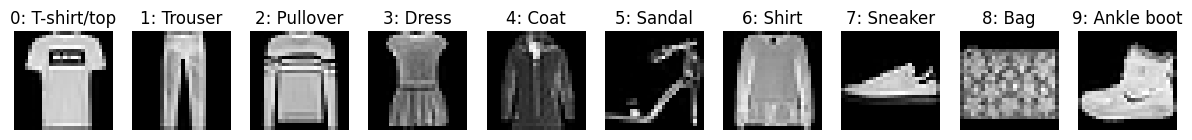

In [5]:
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    axs[i].imshow(training_data.data[training_data.targets == i][0], cmap='gray')
    axs[i].set_title(f"{i}: {training_data.classes[i]}")
    axs[i].axis('off')

### Preparing Data for training

In [6]:
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Defining the CNN-Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.network = Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(in_features=32 * 7 * 7, out_features=128), # 7*7 is the image dim after 2x MaxPool
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [8]:
cnn = CNN().to(device)
summary(cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
           Flatten-9                 [-1, 1568]               0
           Linear-10                  [-1, 128]         200,832
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 220,938
Trainable params: 220,938
Non-trainable params: 0
-------------------------------

## Training and evaluating loop

In [10]:
n_epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.003)

train_accs = []
train_losses = []
val_accs = []
val_losses = []

for i, epoch in tqdm(enumerate(range(n_epochs)), desc="Epoch"):
    cnn.train()

    total_correct = 0
    total_train_loss = 0.0

    for X_train, y_train in train_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        output = cnn(X_train)

        optimizer.zero_grad()
        loss = loss_fn(output, y_train)

        loss.backward()

        total_train_loss += loss.item()

        optimizer.step()

        _, y_pred = torch.max(output, dim=1)
        correct = torch.sum(y_pred == y_train).item()
        total_correct += correct

    with torch.no_grad():
        acc = total_correct / len(train_loader.dataset)
        cost = total_train_loss / len(train_loader)

        cnn.eval()

        val_loss = 0
        total_correct = 0
        total_preds = []
        total_targets = []

        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            output = cnn(X_test)
            loss = loss_fn(output, y_test).item()
            val_loss += loss

            _, y_pred = torch.max(output, dim=1)
            correct = torch.sum(y_pred == y_test).item()
            total_correct += correct
            total_preds.append(y_pred.detach().cpu())
            total_targets.append(y_test.cpu())
        acc_val = total_correct / len(test_loader.dataset)
        cost_val = val_loss / len(test_loader)

        train_losses.append(cost)
        val_losses.append(cost_val)
        train_accs.append(acc)
        val_accs.append(acc_val)
        print(f"Epoch {i}")
        print(f"Train --> Loss : {cost:.3f}, Acc: {acc:.3f}")
        print(f"Val   --> Loss : {cost_val:.3f}, Acc: {acc_val:.3f}")
    print("----------------------------------------")

Epoch: 1it [00:16, 16.82s/it]

Epoch 0
Train --> Loss : 0.251, Acc: 0.908
Val   --> Loss : 0.280, Acc: 0.902
----------------------------------------


Epoch: 2it [00:33, 16.70s/it]

Epoch 1
Train --> Loss : 0.209, Acc: 0.924
Val   --> Loss : 0.237, Acc: 0.915
----------------------------------------


Epoch: 3it [00:49, 16.53s/it]

Epoch 2
Train --> Loss : 0.187, Acc: 0.931
Val   --> Loss : 0.240, Acc: 0.910
----------------------------------------


Epoch: 4it [01:06, 16.56s/it]

Epoch 3
Train --> Loss : 0.161, Acc: 0.939
Val   --> Loss : 0.238, Acc: 0.913
----------------------------------------


Epoch: 5it [01:22, 16.34s/it]

Epoch 4
Train --> Loss : 0.144, Acc: 0.947
Val   --> Loss : 0.235, Acc: 0.914
----------------------------------------


Epoch: 6it [01:37, 16.11s/it]

Epoch 5
Train --> Loss : 0.128, Acc: 0.952
Val   --> Loss : 0.255, Acc: 0.915
----------------------------------------


Epoch: 7it [01:53, 15.91s/it]

Epoch 6
Train --> Loss : 0.111, Acc: 0.959
Val   --> Loss : 0.254, Acc: 0.919
----------------------------------------


Epoch: 8it [02:09, 15.84s/it]

Epoch 7
Train --> Loss : 0.100, Acc: 0.962
Val   --> Loss : 0.307, Acc: 0.915
----------------------------------------


Epoch: 9it [02:24, 15.80s/it]

Epoch 8
Train --> Loss : 0.091, Acc: 0.966
Val   --> Loss : 0.315, Acc: 0.916
----------------------------------------


Epoch: 10it [02:41, 16.13s/it]

Epoch 9
Train --> Loss : 0.082, Acc: 0.969
Val   --> Loss : 0.311, Acc: 0.912
----------------------------------------


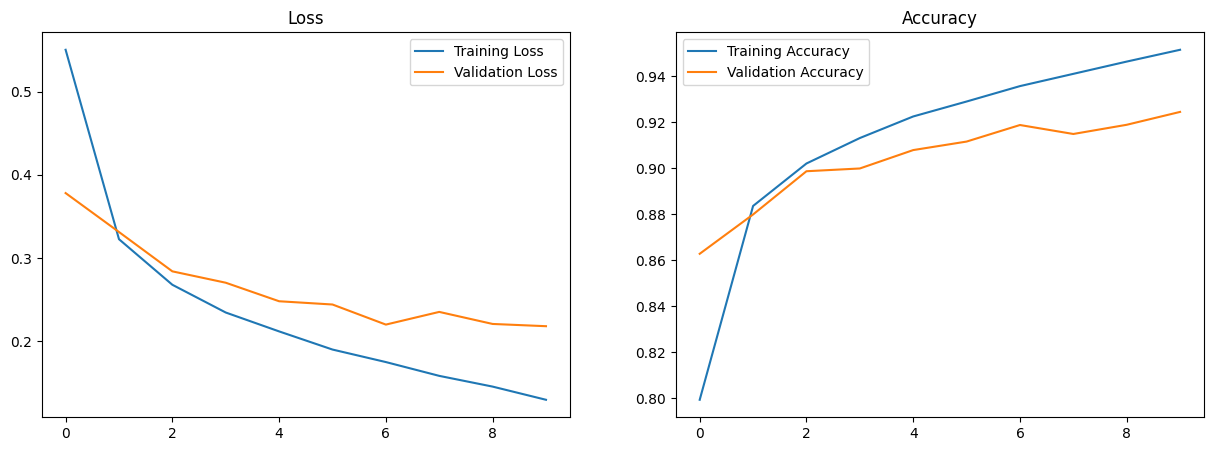

In [32]:
plt.figure(1, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## Grad CAM

In [11]:
def hook_store_A(module, input, output):
    module.A = output[0]

def hook_store_dydA(module, grad_input, grad_output):
    module.dydA = grad_output[0]

In [12]:
last_relu = cnn.network[6]
print(last_relu)
last_relu.register_forward_hook(hook_store_A)
last_relu.register_backward_hook(hook_store_dydA)

ReLU()


In [15]:
to_tensor = torchvision.transforms.ToTensor()

def plot_grad_cam(model, img, c, layer):
    if isinstance(img, torch.Tensor):
        input = img.unsqueeze(0).unsqueeze(0).to(device)
    else:
        input = to_tensor(img.resize((28, 28)))
        input = torch.mean(input, 0, keepdim=True)
        input = input.unsqueeze(0).to(device)
    output = model(input)

    output[0, c].backward()

    alpha = layer.dydA.mean((0, 1), keepdim=True)
    L = torch.relu((alpha * layer.A).sum(1, keepdim=True))

    L = L.to('cpu')
    L = L / L.max()
    L = F.interpolate(L, size=(input.size(2), input.size(3)),
                    mode='bilinear', align_corners=False)
    l = L.view(L.size(2), L.size(3)).detach().numpy()

    PIL.Image.fromarray(np.uint8(cm.gist_earth(l) * 255)).save('result.png')

    plt.figure(1, figsize=(5, 5))
    plt.subplot2grid((1, 2), (0, 0))
    plt.imshow(img, cmap='gray')
    plt.title(f'{c}: {training_data.classes[c]}')
    plt.subplot2grid((1, 2), (0, 1))
    plt.imshow(img, cmap='gray')
    plt.imshow(PIL.Image.open('result.png'), alpha=0.5)
    plt.title('Grad CAM overlayed')
    plt.show()

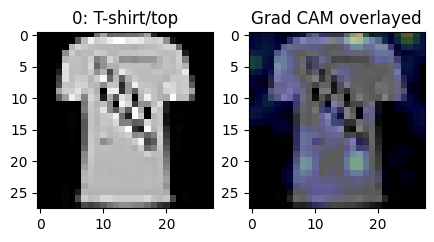

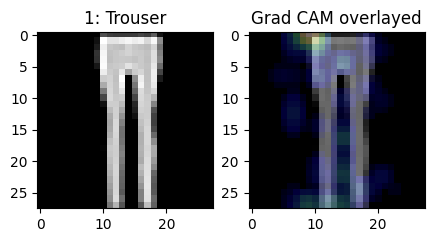

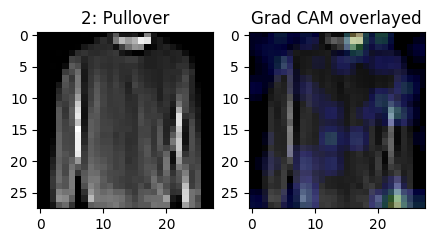

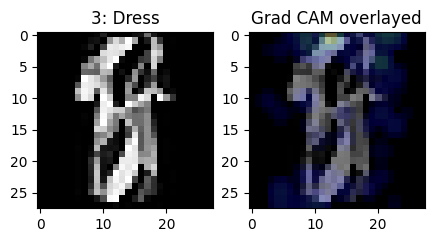

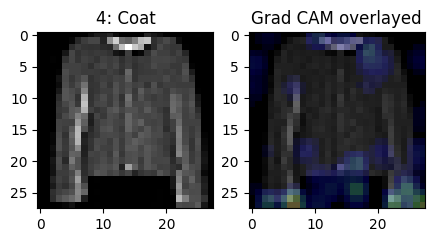

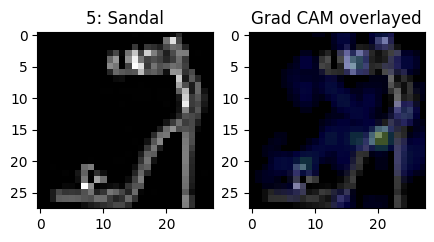

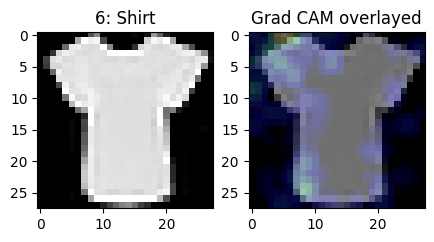

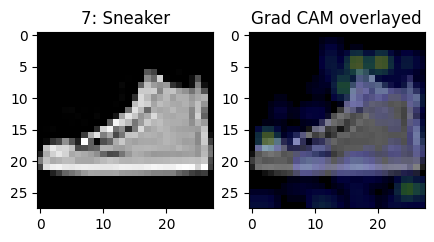

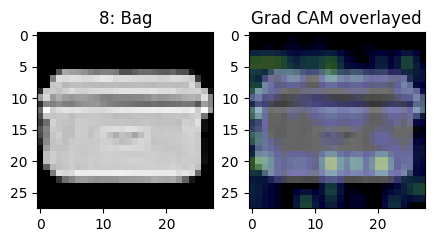

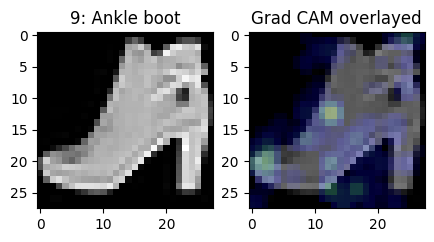

In [26]:
for i in range(10):
    data = training_data.data[training_data.targets == i]
    size = len(data)
    img = data[random.randint(0, size - 1)]
    # convert to float
    img = img.to(torch.float32)
    plot_grad_cam(cnn, img, i, last_relu)